In [1]:
import numpy as np

In [2]:
A = np.zeros((20, 20))

In [3]:
np.random.seed(42)

In [4]:
A_centers=[np.random.choice(20, 2) for i in range(3)]

In [5]:
for y in range(20):
  for x in range(20):
    A[y,x] = np.sum([np.exp(-np.linalg.norm([y_1-y, x_1-x])**2/9) for [y_1,x_1] in A_centers])

In [6]:
import matplotlib.pyplot as plt

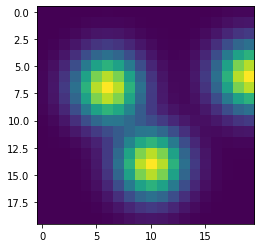

In [7]:
plt.imshow(A)

In [8]:
MAP_DIM=20

In [9]:
def gen_latent_2d(num_centers=3, sigma=9, seed=42):
  rs = np.random.RandomState(seed=seed)
  A = np.zeros((MAP_DIM, MAP_DIM))
  A_centers=[rs.choice(20, 2) for i in range(num_centers)]
  for y in range(MAP_DIM):
    for x in range(MAP_DIM):
      A[y,x] = np.sum([np.exp(-np.linalg.norm([y_1-y, x_1-x])**2/sigma) for [y_1,x_1] in A_centers])
  return A

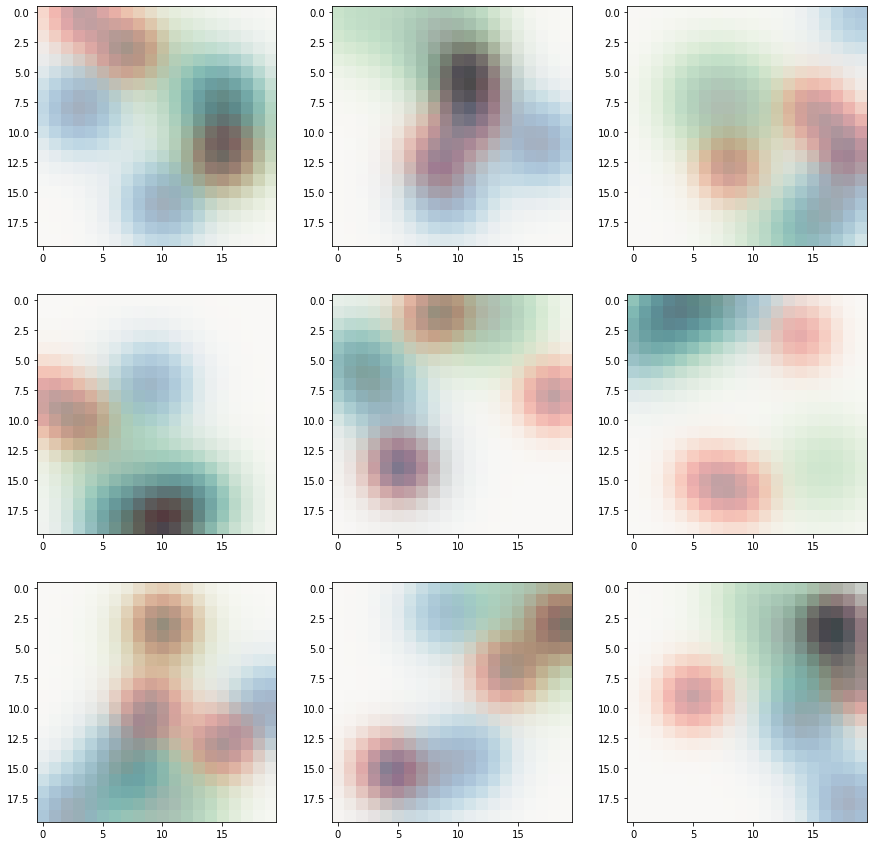

In [10]:
f, axarr = plt.subplots(3,3, figsize=(15,15)) 

for x in range(9):
  axarr[np.unravel_index(x, (3,3))].imshow(gen_latent_2d(sigma=9, seed=x), cmap=plt.cm.Reds)
  axarr[np.unravel_index(x, (3,3))].imshow(gen_latent_2d(sigma=16, seed=100+x), alpha=0.5, cmap=plt.cm.Blues)
  axarr[np.unravel_index(x, (3,3))].imshow(gen_latent_2d(sigma=25, seed=200+x), alpha=0.3, cmap=plt.cm.Greens)

plt.show()

In [13]:
A,B,C = gen_latent_2d(sigma=9, seed=0), gen_latent_2d(sigma=16, seed=100), gen_latent_2d(sigma=25, seed=200)

In [14]:
np.unravel_index(np.random.choice(a=MAP_DIM**2,p=(A.flatten() + B.flatten() + C.flatten())/np.sum(A.flatten() + B.flatten() + C.flatten())), (MAP_DIM, MAP_DIM))

(11, 8)

In [15]:
C_probs=(A.flatten() + B.flatten() + C.flatten())/np.sum(A.flatten() + B.flatten() + C.flatten())

In [16]:
C_rawpreds=np.random.choice(a=MAP_DIM**2, size=20, p=C_probs, replace=False)
C_preds=[np.unravel_index(C_rawpreds, (MAP_DIM, MAP_DIM)) for _ in range(20)]

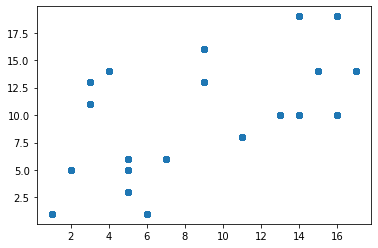

In [17]:
plt.scatter(*zip(*C_preds))

# Transportation Problem

In [ ]:
# !pip install ortools

In [236]:
from ortools.linear_solver import pywraplp

In [237]:
solver = pywraplp.Solver.CreateSolver('SCIP')
objective = solver.Objective()

In [238]:
# x_ij denotes a flow from i to j
x_ijs = [[solver.IntVar(0,1,f'x_{i}_{j}') for j in range(MAP_DIM**2)] for i in range(MAP_DIM**2)]

In [239]:
# Objective to minimize the flow

for i in range(MAP_DIM**2):
  for j in range(MAP_DIM**2):
    x = np.unravel_index(i, (MAP_DIM, MAP_DIM))
    y = np.unravel_index(j, (MAP_DIM, MAP_DIM))
    objective.SetCoefficient(x_ijs[i][j], float(abs(x[0]-y[0]) + abs(x[1] - y[1])))

In [240]:
sources = [solver.Constraint(0, 1) for i in range(MAP_DIM**2)]
sinks = [solver.Constraint(1, 1) if i in C_rawpreds else solver.Constraint(0,0) for i in range(MAP_DIM**2)]

In [241]:
for i in range(MAP_DIM**2):
  for j in range(MAP_DIM**2):
    x_ij = x_ijs[i][j]
    sources[i].SetCoefficient(x_ij, 1)
    sinks[j].SetCoefficient(x_ij, 1)

In [242]:
objective.SetMinimization()

In [243]:
solver.Solve()

0

In [244]:
for i in range(MAP_DIM**2):
  for j in range(MAP_DIM**2):
    s=x_ijs[i][j].solution_value()
    if s>0:
      print(f'x_{i}_{j} = {s} * {objective.GetCoefficient(x_ijs[i][j])}')

x_21_21 = 1.0 * 0.0
x_93_93 = 1.0 * 0.0
x_116_116 = 1.0 * 0.0
x_133_133 = 1.0 * 0.0
x_153_153 = 1.0 * 0.0
x_159_159 = 1.0 * 0.0
x_170_170 = 1.0 * 0.0
x_190_190 = 1.0 * 0.0
x_194_194 = 1.0 * 0.0
x_199_199 = 1.0 * 0.0
x_200_200 = 1.0 * 0.0
x_209_209 = 1.0 * 0.0
x_214_214 = 1.0 * 0.0
x_252_252 = 1.0 * 0.0
x_255_255 = 1.0 * 0.0
x_292_292 = 1.0 * 0.0
x_293_293 = 1.0 * 0.0
x_332_332 = 1.0 * 0.0
x_354_354 = 1.0 * 0.0
x_356_356 = 1.0 * 0.0


In [245]:
solver.NumVariables()

160000

In [246]:
solver.NumConstraints()

800

# Transportation over multiple projections

In [147]:
# Number of scenarios to run
NUM_S = 2
NUM_K = 50

# Generate scenarios
np.random.seed(10042)
z_s = [np.random.choice(a=MAP_DIM**2, size=20, p=C_probs, replace=False) for _ in range(NUM_S)]

In [148]:
from ortools.sat.python import cp_model
from functools import reduce

In [149]:
model = cp_model.CpModel()

In [150]:
# Global sources
q = [model.NewIntVar(0, NUM_K, f'q_i') for i in range(MAP_DIM**2)]

In [151]:
model.Add(reduce(lambda x,y:x+y, q) == NUM_K)

In [152]:
x_ijs = [[[model.NewIntVar(0, 1, f'x_{i}_{j}_{s}') for s in range(NUM_S)] for j in range(MAP_DIM**2)] for i in range(MAP_DIM**2)]

In [153]:
# Local sources constraint
for s in range(NUM_S):
  for i in range(MAP_DIM**2):
    model.Add(reduce(lambda x,y: x+y, [x_ijs[i][j][s] for j in range(MAP_DIM**2)]) <= q[i])

In [154]:
# Sink constraint per scenario

for s in range(NUM_S):
  z = z_s[s]
  for j in z:
    model.Add(reduce(lambda x,y:x+y, [x_ijs[i][j][s] for i in range(MAP_DIM**2)]) >= 1)

In [155]:
# Set objective.
goals = 0
for i in range(MAP_DIM**2):
  for j in range(MAP_DIM**2):
    a = np.unravel_index(i, (MAP_DIM, MAP_DIM))
    b = np.unravel_index(j, (MAP_DIM, MAP_DIM))
    d = abs(a[0]-b[0]) + abs(a[1] - b[1])
    for s in range(NUM_S):
      x = x_ijs[i][j][s]
      goals += (x*d)

In [156]:
model.Minimize(goals)

In [157]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 120.0

In [158]:
status = solver.Solve(model)

In [159]:
print(status)

2


In [169]:
for i in range(MAP_DIM**2):
    if solver.Value(q[i]) > 0:
        print(f'{i}:{solver.Value(q[i])}')

11:1
12:1
25:1
38:14
50:1
71:1
74:2
87:1
94:2
100:1
101:3
102:1
105:1
129:1
131:1
175:1
184:1
202:1
203:4
204:1
268:1
270:1
288:1
349:3
372:1
382:1
389:1
399:1


In [161]:
solver.Value(q[0])

0

In [162]:
zx = [i for i in range(MAP_DIM**2) if solver.Value(q[i])>0]

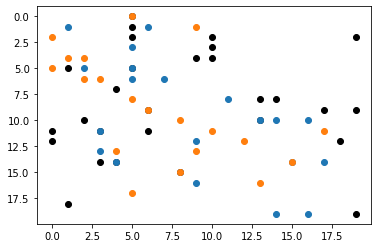

In [168]:
plt.scatter(*np.unravel_index(zx, (MAP_DIM, MAP_DIM)), color='black').axes.invert_yaxis()
for z in z_s:
    plt.scatter(*np.unravel_index(z, (MAP_DIM, MAP_DIM))).axes.invert_yaxis()
plt.show()

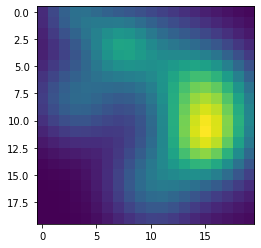

In [164]:
plt.imshow(np.reshape(C_probs, (MAP_DIM, MAP_DIM)))